**Installing datasets and importing required packages**

---



In [ ]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np
from sklearn.svm import SVC
from string import punctuation
from tqdm.notebook import tqdm
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [ ]:
SEED = 0
D = 6  # Number of features used
SW = stopwords.words("english")
PUNCT = list(punctuation)

Data Preparation

In [ ]:
def prepare_data(data):

    # Initializing empty lists to store words, features, and labels
    word_list = []
    feature_list = []
    label_list = []

    # Iterating through each data point using tqdm for progress visualization
    for element in tqdm(data):

        # Extracting tokens and NER tags from the data point
        tokens = element["tokens"]
        ner_tags = element["ner_tags"]

        # Processing each token
        for i, token in enumerate(tokens):

            # Calculating scaled position based on index and total token count
            scaled_position = i / len(tokens)

            # Converting token and scaled position into a feature vector
            feature_vector = create_feature_vector(token, scaled_position)

            # Assigning label based on NER tag (1 for entity, 0 for non-entity)
            label = 1 if ner_tags[i] > 0 else 0

            # Appending feature vector and label to respective lists
            feature_list.append(feature_vector)
            label_list.append(label)

        # Appending tokens to the word list
        word_list.extend(tokens)

    # Convert lists to NumPy arrays for efficient processing
    words = np.array(word_list, dtype="object")
    features = np.array(feature_list, dtype=np.float32)
    labels = np.array(label_list, dtype=np.float32)

    return words, features, labels


**Designing Features for the SVM(6 features)**

In [ ]:
def create_feature_vector(token, scaled_position):
    # the token will be vectorized , scaled position of the token in the sentence

    feature_vector = np.zeros(D, dtype=np.float32)

    # Checking if the first character is uppercase
    is_title = 1 if token[0].isupper() else 0

    # Checking if all characters are uppercase
    is_allcaps = 1 if token.isupper() else 0

    # Checking if the token is a stopword
    is_stopword = 1 if token.lower() in SW else 0

    # Checking if the token is punctuation
    is_punctuation = 1 if token in PUNCT else 0

    # Assigning values to the feature vector
    feature_vector[0] = is_title
    feature_vector[1] = is_allcaps
    feature_vector[2] = len(token)
    feature_vector[3] = is_stopword
    feature_vector[4] = is_punctuation
    feature_vector[5] = scaled_position

    return feature_vector

**`Prediction function through vectorization
`**

In [ ]:
def make_predictions(model, scaler, sentence):
    # sentence: str, the sentence to make predictions for

    # Tokenizing the sentence
    words = word_tokenize(sentence)

    # Creating a list to store feature vectors
    feature_vectors = []

    # Calculating the scaled position for each token
    for i, word in enumerate(words):
        scaled_position = i / len(words)

        # Creating a feature vector for the current token and scaled position
        feature_vector = create_feature_vector(word, scaled_position)

        # Appending the feature vector to the list
        feature_vectors.append(feature_vector)

    # Converting the list of feature vectors to a NumPy array
    features = np.array(feature_vectors, dtype=np.float32)

    # Scaling the features using the trained scaler
    scaled_features = scaler.transform(features)

    # Making predictions using the trained model
    predictions = model.predict(scaled_features)

    return predictions, words, features

**Loading the dataset and dividing the same into train,test and validation sets**

In [ ]:
# Loading the CoNLL-2003 dataset
dataset = load_dataset("conll2003")

# Splitting the dataset into training, validation, and test sets
train_data = dataset["train"]  # 14,041 rows
val_data = dataset["validation"]  # 3250 rows
test_data = dataset["test"]  # 3453 rows



Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
words_train, X_train, y_train = prepare_data(train_data)
words_val, X_validation, y_validation       = prepare_data(val_data)
words_test, X_test, y_test    = prepare_data(test_data)

  0%|          | 0/14041 [00:00<?, ?it/s]

  0%|          | 0/3250 [00:00<?, ?it/s]

  0%|          | 0/3453 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
# (rows,columns respectively)

(203621, 6)
(51362, 6)
(46435, 6)


In [ ]:
# Creating a StandardScaler object for feature scaling
scaler = StandardScaler()

# Fitting the scaler only on the training data (calculate mean and standard deviation)
scaler.fit(X_train)

# Scaling the training, validation, and test features using the trained scaler
scaled_X_train = scaler.transform(X_train)
scaled_X_validation = scaler.transform(X_validation)
scaled_X_test = scaler.transform(X_test)

**Training,testing and saving SVM with linear kernel**



In [ ]:
#Training the SVM model model
model = SVC(C=1.0, kernel="linear", class_weight="balanced", random_state=SEED, verbose=True)
model.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', kernel='linear', random_state=0, verbose=True)

In [ ]:
import pickle


def save_model(model,path):
  with open(path , "wb") as file:
    pickle.dump(model , file)
  print("Saved at " , path)

def load_model(path):
  model = None
  with open(path , "rb") as file:
    model = pickle.load(file)
  print("Loaded from " , path)
  return model

In [ ]:
save_model(model , "SVM.Linear")

In [ ]:
new_model = load_model("SVM.Linear")

Loaded from  SVM.Linear


In [ ]:
y_predicted_validation = new_model.predict(X_validation)

In [ ]:
print(classification_report(y_true = y_validation, y_pred = y_predicted_validation))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     42759
         1.0       0.82      0.97      0.89      8603

    accuracy                           0.96     51362
   macro avg       0.91      0.96      0.93     51362
weighted avg       0.96      0.96      0.96     51362



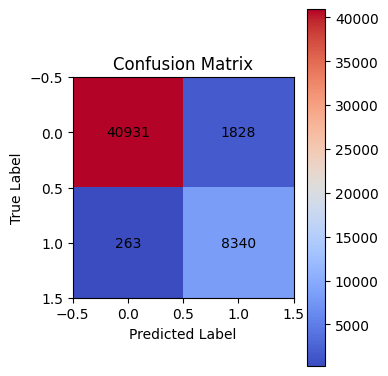

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cf=confusion_matrix(y_validation,y_predicted_validation)
# Create confusion matrix heatmap
plt.figure(figsize=(4, 4))
plt.imshow(cf, cmap="coolwarm")

# Add labels and title
for i in range(cf.shape[0]):
    for j in range(cf.shape[1]):
        plt.text(j, i, cf[i, j], ha="center", va="center")
plt.title("Confusion Matrix")

# Add labels for axes
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the heatmap
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
def sentential(prediction,tokens):
  return f"{prediction}_{int(tokens)} "

In [ ]:

examples = [
     "I deposited the money in the bank near the river-bank"
]


for example in examples:
    pred, tokens, features = make_predictions(new_model, scaler, example)
    annotated = []
    for word, ppred in zip(tokens, pred):
        annotated.append(sentential(word,ppred))
    print(" ".join(annotated))

I_0  deposited_0  the_0  money_0  in_0  the_0  bank_0  near_0  the_0  river-bank_0 


**Training,testing and saving SVM with RBF kernel**

In [ ]:
#Training the SVM model model
model1 = SVC(C=1.0, kernel="rbf", class_weight="balanced", random_state=SEED, verbose=True)
model1.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', random_state=0, verbose=True)

In [ ]:
save_model(model1 , "SVM.Rbf")

Saved at  SVM.Rbf


In [ ]:
new_model1=load_model("SVM.Rbf")

Loaded from  SVM.Rbf


In [ ]:
y_predicted_validation = new_model1.predict(X_validation)

In [ ]:
print(classification_report(y_true = y_validation, y_pred = y_predicted_validation))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     42759
         1.0       0.82      0.97      0.89      8603

    accuracy                           0.96     51362
   macro avg       0.91      0.96      0.93     51362
weighted avg       0.96      0.96      0.96     51362



In [ ]:
print(confusion_matrix(y_validation,y_predicted_validation))

[[40930  1829]
 [  263  8340]]


In [ ]:
def sentential(prediction,tokens):
  return f"{prediction}_{int(tokens)} "

In [ ]:

examples = [
    "Kolkata is the capital of West Bengal.",
     "Swapnil is a student."
]


for example in examples:
    pred, tokens, features = make_predictions(model1, scaler, example)
    annotated = []
    for word, ppred in zip(tokens, pred):
        annotated.append(sentential(word,ppred))
    print(" ".join(annotated))
    print()